## Importing libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import uuid

## load the data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [3]:
df = pd.read_csv('diabetes.csv')

## Understand the data

In [4]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


 displays the first five rows of the DataFrame

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


.info() method provides a concise summary of the DataFrame. It shows the number of non-null entries in each column and their data types. As shown, all of the features are int except BMI and  DiabetesPedigreeFunction, they are  Floats

In [6]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

The .describe() method generates descriptive statistics that summarize the central tendency, dispersion, and shape of the dataset's distribution. This includes counts, mean, standard deviation, and quartiles for each numerical column.

In [7]:
# Check the distribution of the target variable
print(df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


This code counts the occurrences of each unique value in the Outcome column, which is our target variable. This is crucial for checking if the dataset is balanced (an equal number of diabetic and non-diabetic outcomes) or imbalanced. As shown, almost 65% of the patients are not diabetec while the rest 34.89% are diabetec.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

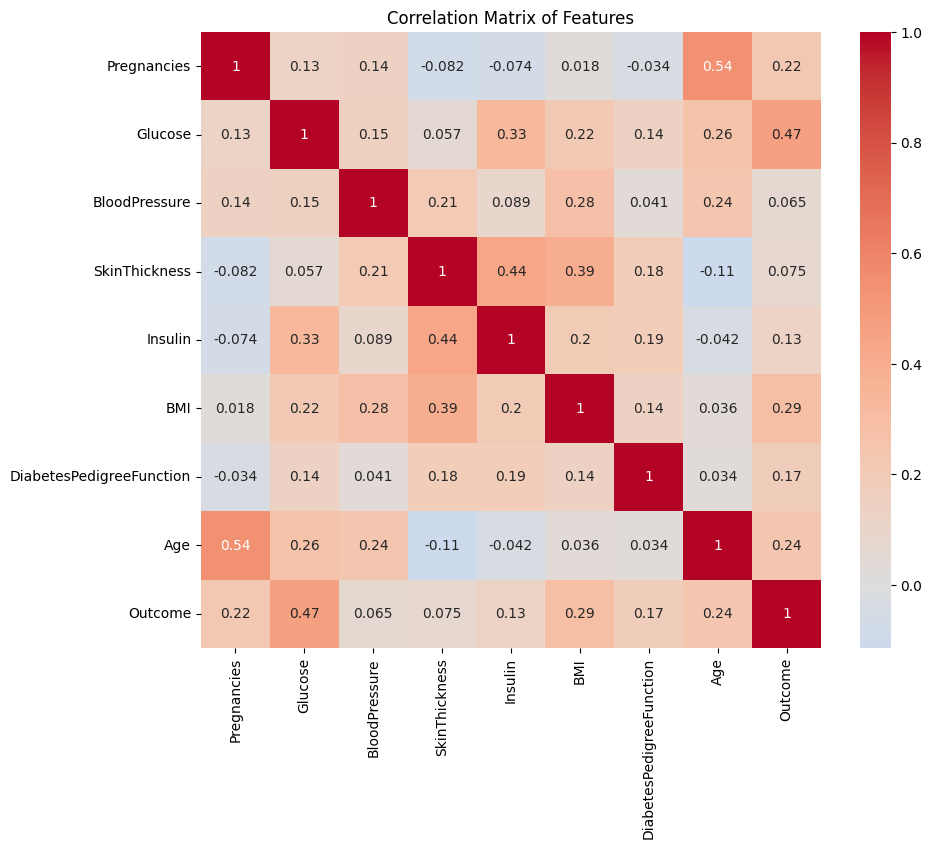

In [16]:
# Correlation matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

This code generates a heatmap to visualize the correlation matrix of the features in the dataset.

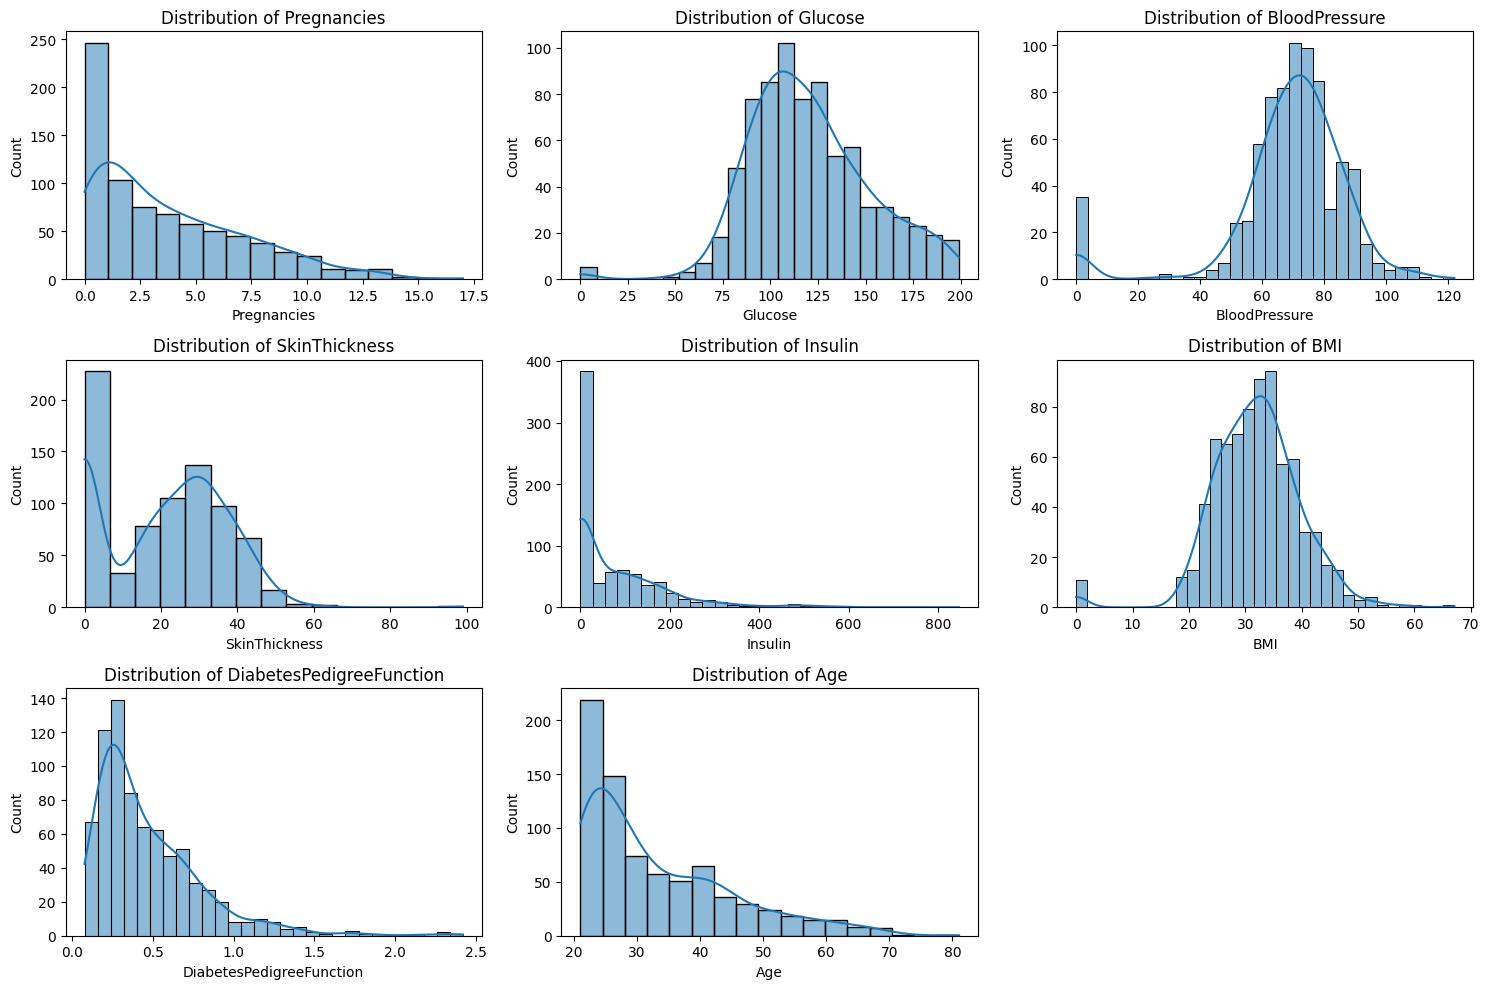

In [17]:
# Visualize feature distributions
features = df.drop('Outcome', axis=1).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data preparation

In [10]:
#Check for missing values (0s in specific columns)
zero_counts = {col: (df[col] == 0).sum() for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']}
for col, count in zero_counts.items():
    print(f"{col}: {count} zeros")

Glucose: 5 zeros
BloodPressure: 35 zeros
SkinThickness: 227 zeros
Insulin: 374 zeros
BMI: 11 zeros


In [8]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [9]:
#some columns like 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI'
# have a minimum value of 0, which is not biologically plausible for these measurements.
# We will handle this in the next phase by replacing the 0s with the median.
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_impute:
    X[col] = X[col].replace(0, X[col].median())

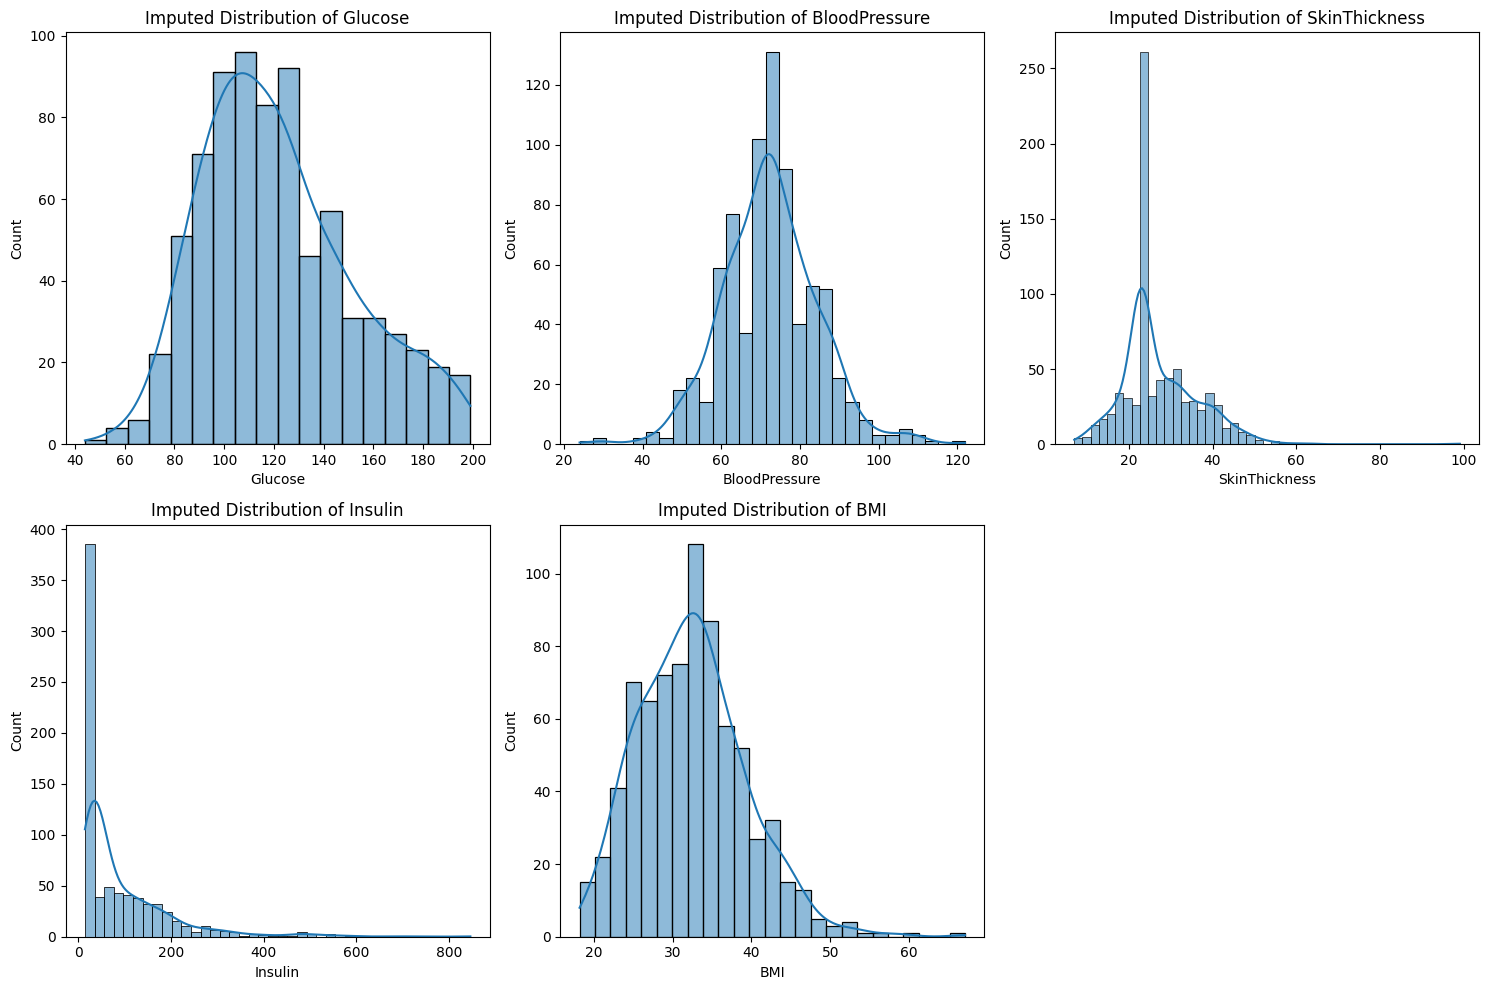

In [18]:
# Visualize imputed data
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_impute, 1):
    plt.subplot(2, 3, i)
    sns.histplot(X[col], kde=True)
    plt.title(f'Imputed Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## MODELING

In [19]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

initializes a StandardScaler. Feature scaling is crucial for many machine learning algorithms, especially those that rely on distance calculations like Support Vector Machines (SVM). This ensures all features contribute equally to the model, preventing features with larger values from dominating the learning process.

In [21]:
# Model 1: Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

In [27]:
print("\nLinear Regression Performance:")
print(classification_report(y_test, lr_pred))


Linear Regression Performance:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



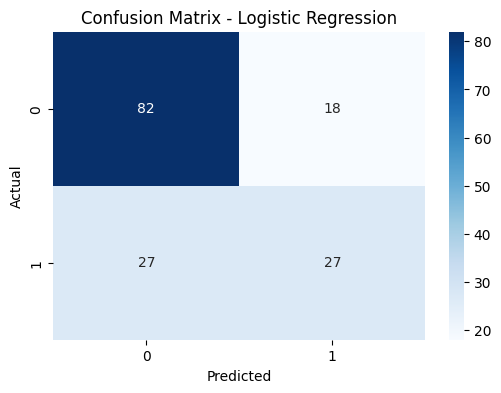

In [23]:
# Confusion matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
# Model 2: Support Vector Machine (SVM)
svm_model = SVC(random_state=42, probability=True)
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

This cell defines the hyperparameters that will be tuned for the Support Vector Machine (SVM) model.

C: The regularization parameter, which controls the trade-off between a smooth decision boundary and correctly classifying training points.

gamma: The kernel coefficient for the 'rbf' kernel, which influences the shape of the decision boundary.

In [25]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_svm = grid_search.best_estimator_
svm_pred = best_svm.predict(X_test_scaled)
print(f"\nBest Hyperparameters for SVM: {grid_search.best_params_}")


Best Hyperparameters for SVM: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


This code performs Grid Search Cross-Validation.

It systematically works through all combinations of hyperparameters specified in param_grid.

For each combination, it trains and evaluates the model using cross-validation to find the best-performing set of hyperparameters.

In [26]:
print("\nSupport Vector Machine (SVM) Performance:")
print(classification_report(y_test, svm_pred))


Support Vector Machine (SVM) Performance:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



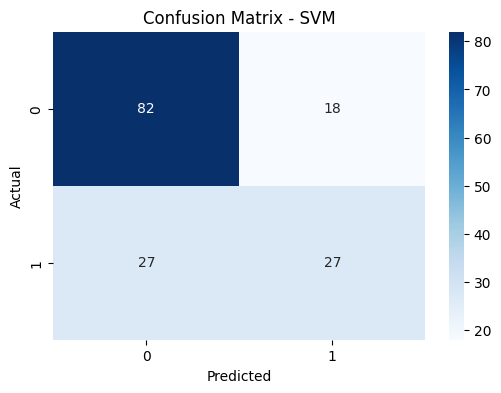

In [28]:
# Confusion matrix for SVM
svm_cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
# ROC Curve Comparison
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

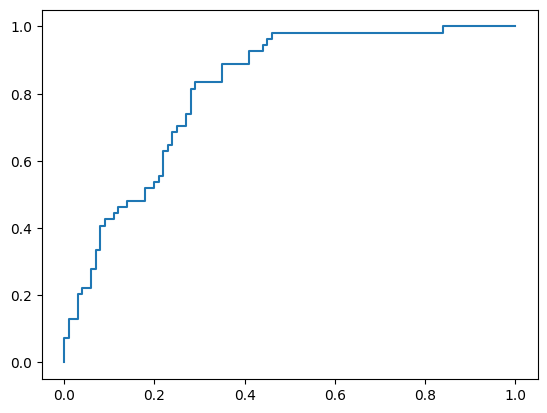

In [30]:
# Logistic Regression ROC
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')

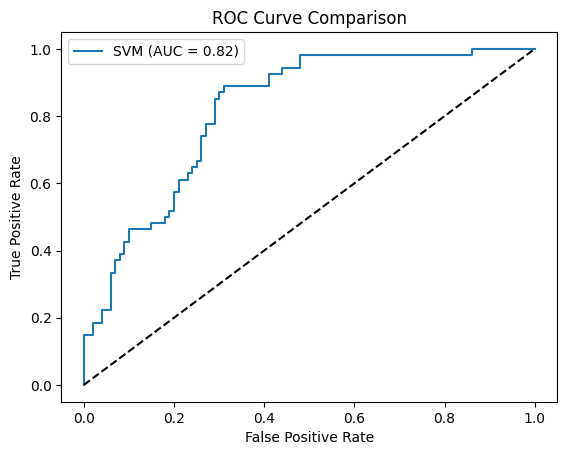

In [31]:
# SVM ROC
svm_probs = best_svm.predict_proba(X_test_scaled)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()

In [33]:
# Model Comparison
lr_accuracy = lr_model.score(X_test_scaled, y_test)
svm_accuracy = best_svm.score(X_test_scaled, y_test)
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.4f}")
print(f"Tuned SVM Test Accuracy: {svm_accuracy:.4f}")
if svm_accuracy > lr_accuracy:
    print("\nThe SVM model with hyperparameter tuning performs better based on accuracy and AUC.")
    best_model = best_svm
else:
    print("\nThe Logistic Regression model performs better based on accuracy and AUC.")
    best_model = lr_model

Logistic Regression Test Accuracy: 0.7078
Tuned SVM Test Accuracy: 0.7078

The Logistic Regression model performs better based on accuracy and AUC.


## prediction engine

In [34]:

def predict_diabetes(new_patient_data):
    """
    Predicts diabetes status for a new patient using the best-performing model.

    Args:
        new_patient_data (list or array-like): A single row of patient data,
        containing 8 features in the same order as the dataset:
        [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI,
         DiabetesPedigreeFunction, Age]

    Returns:
        str: "Diabetic" or "Non-Diabetic" with confidence score
    """
    # Convert data to a numpy array and reshape for the scaler
    new_patient_data = np.array(new_patient_data).reshape(1, -1)

    # Impute 0 values if present (matches our data preparation step)
    for i, val in enumerate(new_patient_data[0]):
        if val == 0 and i in [1, 2, 3, 4, 5]:  # Corresponds to Glucose, BP, Skin, Insulin, BMI
            new_patient_data[0, i] = X[columns_to_impute[i-1]].median()

    # Standardize the new data using the same scaler fitted on the training data
    scaled_data = scaler.transform(new_patient_data)

    # Make a prediction using the best-performing model
    prediction = best_model.predict(scaled_data)
    confidence = best_model.predict_proba(scaled_data)[0][prediction[0]] if hasattr(best_model, 'predict_proba') else None

    # Return the result as a human-readable string
    result = "Diabetic" if prediction[0] == 1 else "Non-Diabetic"
    if confidence:
        return f"{result} (Confidence: {confidence:.2%})"
    return result


In [35]:
# Example usage of the prediction engine
# Example patient 1 (similar to a diabetic patient from the dataset)
example_diabetic = [8, 183, 64, 0, 0, 23.3, 0.672, 32]
prediction_1 = predict_diabetes(example_diabetic)
print(f"Prediction for example patient 1: {prediction_1}")
# Example patient 2 (similar to a non-diabetic patient from the dataset)
example_non_diabetic = [1, 85, 66, 29, 0, 26.6, 0.351, 31]
prediction_2 = predict_diabetes(example_non_diabetic)
print(f"Prediction for example patient 2: {prediction_2}")

Prediction for example patient 1: Diabetic (Confidence: 79.76%)
Prediction for example patient 2: Non-Diabetic (Confidence: 96.37%)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
